<a href="https://colab.research.google.com/github/SWainty24/ATSC528/blob/main/01-Function_Fitting/function_fitting_SW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
Analysis of 500-mb geoptential height value on a polar stretographic projection



"""
__author__    = "Jared W. Marquis"
__edited_by__= "Sharhad Wainty"
__contact__   = "jared.marquis@und.edu"

In [2]:
#Used Colab for further works, supports Pip
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 78.9 MB/s eta 0:00:00


In [3]:
### Import Required Modules  ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [4]:
### Loaded the observation files from session storage on Colab###
data_path = '/content/RAOBs_201903131200.txt'
data = np.genfromtxt(data_path, delimiter=',', dtype=str)

# Individual columns for each data
station_ids = data[:, 0]  # Station IDs
station_lat = data[:, 1].astype(float)  # Latitude values
station_lon = data[:, 2].astype(float)  # Longitude values
heights = data[:, 3].astype(float)  # 500-mb Height


In [5]:
phi0 = np.radians(60)  # central latitude φ0 in radians
lambda0 = np.radians(-115)
lat_rad=np.radians (station_lat)
lon_rad=np.radians(station_lon) # central longitude λ0 in radians
R = 6371*1000  # Earth's radius in meters
m = 1 / 15000000  # map scale

In [6]:
proj= ccrs.Stereographic(central_latitude=90, central_longitude=-115,true_scale_latitude=60)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


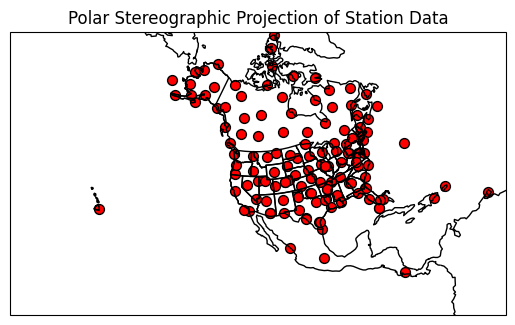

In [7]:
#Plotting the obs location on map
fig, ax = plt.subplots(subplot_kw={'projection': proj})

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.set_extent([station_lon.min() - 1, station_lon.max() + 1, station_lat.min() - 1, station_lat.max() + 1], crs=ccrs.PlateCarree())
ax.scatter(station_lon, station_lat, color='red', s=50, edgecolor='k', transform=ccrs.PlateCarree())
plt.title('Polar Stereographic Projection of Station Data')
plt.show()

Shape of x_grid: (22,)
Shape of y_grid: (28,)


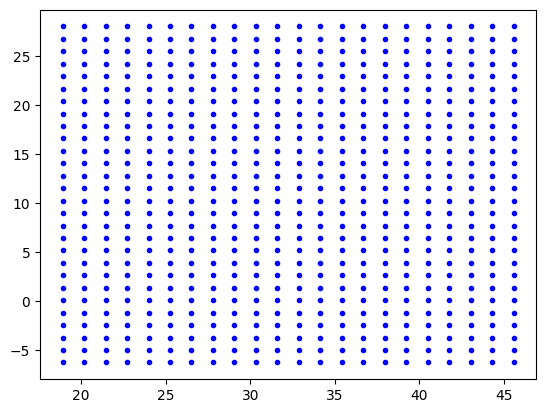

In [8]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x0, y0 = 18.90, -6.30
dx, dy = 1.27, 1.27
nx, ny = 22,28
# Making a (22x28) grid
x_grid = np.linspace(x0, x0 + (nx - 1) * dx, nx)
y_grid = np.linspace(y0, y0 + (ny - 1) * dy, ny)

X, Y = np.meshgrid(x_grid, y_grid)
print("Shape of x_grid:", x_grid.shape)
print("Shape of y_grid:", y_grid.shape)
plt.scatter(X, Y, color='blue', label='Grid Points', marker='.')

obs_coords shape: (135, 2)


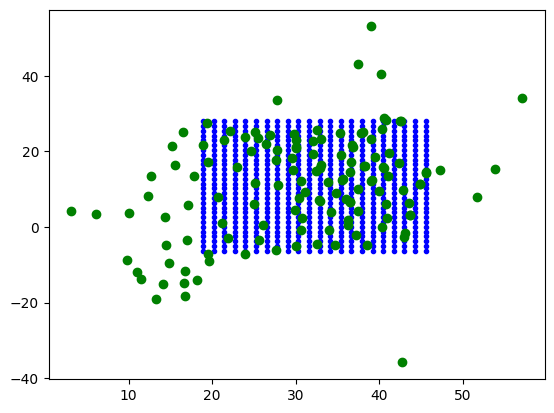

In [9]:
# Function to convert latitude and longitude to x, y in stereographic projection
def latlon_to_xy(station_lat, station_lon):

  lat_rad = np.radians(station_lat)
  lon_rad = np.radians(station_lon)

  sigma = (1+np.sin(phi0)) / (1+np.sin(lat_rad))

  x_obs = R * sigma * m *np.cos(lat_rad)*np.cos(np.radians(station_lon)-lambda0)*100

  y_obs = R * sigma * m *np.cos(lat_rad)*np.sin(np.radians(station_lon)-lambda0)*100



  return x_obs, y_obs

# Apply the function to all latitude and longitude values
obs_coords = np.array([latlon_to_xy(lat, lon) for lat, lon in zip(station_lat, station_lon)])

# Separate x and y coordinates
xk, yk = obs_coords[:, 0], obs_coords[:, 1]
# Check the shape of obs_coords
print(f"obs_coords shape: {obs_coords.shape}")

#Plot the Stations and the Grid to Verify Alignment (I got wrong here somewhere)
plt.scatter(X, Y, color='blue', label='Grid Points', marker='.')  # Plot the grid points
plt.scatter(xk, yk, color='green', label='Converted Station Positions', marker='o')  # Plot station positions

**Minimum distance calculation**

In [10]:
# minimum distance calculation
def haversine(lat1, lon1, lat2, lon2):

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    #d = 2R × sin⁻¹(√[sin²((θ₂ - θ₁)/2) + cosθ₁ × cosθ₂ × sin²((φ₂ - φ₁)/2)])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c  # Distance in kilometers

def average_min_distance(latitudes, longitudes):
    n_points = len(latitudes)
    min_distances = np.full(n_points, np.inf)

    # Calculate minimum Haversine distance for each point
    for i in range(n_points):
        distances = np.array([haversine(latitudes[i], longitudes[i], latitudes[j], longitudes[j]) for j in range(n_points) if i != j])
        min_distances[i] = np.min(distances)  # Minimum distance to other points

    # Calculate the average of these minimum distances
    return np.mean(min_distances)

d_min = average_min_distance(station_lat, station_lon)*m*1000
print("Average of minimum distances between points:", d_min)


Average of minimum distances between points: 22.643698175596306


**Radius of influence**

In [11]:
#Radius of inflence
R1=4*d_min
R2=2.5*d_min
R3=1.5*d_min
print(R1, R2, R3)

90.57479270238522 56.60924543899077 33.965547263394456


**Cressman weighting function**

In [12]:
def cressman_weight(dik_squared, RoI):
    if np.isscalar(dik_squared):
        if dik_squared <= RoI**2:
            return (RoI**2 - dik_squared) / (RoI**2 + dik_squared)
        else:
            return 0  # Outside the radius of influence
    else:
        # Handle array values by applying the condition element-wise
        weights = np.where(dik_squared <= RoI**2, (RoI**2 - dik_squared) / (RoI**2 + dik_squared), 0)
        return weights

**First pass analysis**

In [13]:
def cressman_analysis(xk, yk, observation_heights, X, Y, RoI):

    grid_estimated_values = np.full(X.shape, np.nan)  # Initialize grid with NaNs

    # Loop over each grid point to estimate its value
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            grid_x, grid_y = X[i, j], Y[i, j]
            weighted_sum = 0
            weight_sum = 0

            # Loop over each observation point
            for k in range(len(xk)):
                obs_x, obs_y = xk[k], yk[k]
                obs_height = observation_heights[k]
                distance = np.sqrt((grid_x - obs_x) ** 2 + (grid_y - obs_y) ** 2)

                # Only use observation points within the radius of influence
                if distance <= R:
                    weight = (R**2 - distance**2) / (R**2 + distance**2)
                    weighted_sum += weight * obs_height
                    weight_sum += weight

            # Calculate the weighted average if there are contributing observation points
            if weight_sum > 0:
                grid_estimated_values[i, j] = weighted_sum / weight_sum
            else:
                grid_estimated_values[i, j] = np.nan  # No observation points within radius

    return grid_estimated_values

In [14]:
Analysis1 = cressman_analysis(xk,yk, heights, X,Y,R1)
print(Analysis1.shape)

(28, 22)


**Bilinear interpolation for next passes**

In [15]:

def bilinear_interpolation(xk, yk, X, Y, values, RoI):
    interpolated_values = []

    for x, y in zip(xk, yk):
        # Locate indices of the grid points surrounding (x, y)
        x1_idx = np.searchsorted(X[0], x) - 1
        x2_idx = x1_idx + 1
        y1_idx = np.searchsorted(Y[:, 0], y) - 1
        y2_idx = y1_idx + 1

        # Ensure indices are within bounds of the grid
        if x1_idx < 0 or x2_idx >= X.shape[1] or y1_idx < 0 or y2_idx >= Y.shape[0]:
            interpolated_values.append(np.nan)  # Assign NaN if outside grid bounds
            continue

        # Retrieve the grid points and values for interpolation
        x1, x2 = X[0, x1_idx], X[0, x2_idx]
        y1, y2 = Y[y1_idx, 0], Y[y2_idx, 0]

        # Ensure f11, f21, f12, f22 are within the bounds
        f11 = values[y1_idx, x1_idx] if (y1_idx < values.shape[0] and x1_idx < values.shape[1]) else np.nan
        f21 = values[y1_idx, x2_idx] if (y1_idx < values.shape[0] and x2_idx < values.shape[1]) else np.nan
        f12 = values[y2_idx, x1_idx] if (y2_idx < values.shape[0] and x1_idx < values.shape[1]) else np.nan
        f22 = values[y2_idx, x2_idx] if (y2_idx < values.shape[0] and x2_idx < values.shape[1]) else np.nan

        # Calculate distances for interpolation
        dx = (x - x1) / (x2 - x1) if (x2 - x1) != 0 else 0
        dy = (y - y1) / (y2 - y1) if (y2 - y1) != 0 else 0

        # Perform bilinear interpolation, handling any NaN values
        interpolated_value = (1 - dx) * (1 - dy) * f11 + dx * (1 - dy) * f21 + \
                             (1 - dx) * dy * f12 + dx * dy * f22
        interpolated_values.append(interpolated_value)

    return np.array(interpolated_values)


In [16]:
interpolated_values = bilinear_interpolation(xk, yk, X, Y, Analysis1, R1)
print(interpolated_values.shape)

(135,)


**Cressman interpolation for out of bound values**

In [17]:
def out_of_bound_estimates(xk, yk, observation_heights, X, Y, RoI):
    """
    Use Cressman interpolation to estimate values at observation points outside the grid domain.
    """
    estimated_values = []
    for obs_x, obs_y, obs_value in zip(xk, yk, observation_heights):
        weighted_sum, weight_sum = 0, 0
        is_within_bounds = False

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                grid_x, grid_y = X[i, j], Y[i, j]
                distance = np.sqrt((obs_x - grid_x) ** 2 + (obs_y - grid_y) ** 2)

                if distance<RoI:
                    weight = (RoI**2 - distance**2) / (RoI**2 + distance**2)
                    weighted_sum += weight * obs_value
                    weight_sum += weight
                    is_within_bounds = True

        if is_within_bounds:
            estimated_values.append(weighted_sum / weight_sum)
        else:
            estimated_values.append(np.nan)  # No grid points within radius

    return np.array(estimated_values)

**Cressman analysis for multiple passes**

In [27]:
def cressman_multi_pass(xk, yk, observation_heights, X, Y, initial_estimate, RoI, num_passes):

    initial_grid_estimates = bilinear_interpolation(xk, yk, X, Y, initial_estimate, RoI)

    # Copy initial estimates to start with grid_estimated_values
    grid_estimated_values = initial_grid_estimates.copy()
    # Start with initial grid estimates
    grid_estimated_values = initial_estimate.copy()

    for pass_num in range(num_passes):
        # Create a new grid to hold updated values for this pass
        new_grid_estimated_values = grid_estimated_values.copy()

        # Loop over each grid point
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                grid_x, grid_y = X[i, j], Y[i, j]
                weighted_sum, weight_sum = 0, 0

                # Loop over each observation point
                for k in range(len(xk)):
                    obs_x, obs_y = xk[k], yk[k]
                    obs_value = observation_heights[k]
                    distance = np.sqrt((grid_x - obs_x)**2 + (grid_y - obs_y)**2)

                    # Only consider observations within the radius of influence
                    if distance <= RoI:
                        weight = cressman_weight(distance, RoI)
                        diff = obs_value - grid_estimated_values[i, j]
                        weighted_sum += weight * diff
                        weight_sum += weight

                # Update the grid point if there were contributing observation points
                if weight_sum > 0:
                    new_grid_estimated_values[i, j] = initial_estimate[i, j] + (weighted_sum / weight_sum)

        # Update grid for the next pass
        grid_estimated_values = new_grid_estimated_values

    return grid_estimated_values


In [28]:
# Step 3: Run multi-pass Cressman analysis to refine analysis values
Analysis2 = cressman_multi_pass(xk, yk, heights, X, Y, Analysis1, R2, 2)

In [29]:
# Step 3: Run multi-pass Cressman analysis to refine analysis values
Analysis3 = cressman_multi_pass(xk, yk, heights, X, Y, Analysis2, R3, 3)
Analysis3.shape

(28, 22)

**Compute differences**

In [30]:
diff_2_1 = Analysis2 - Analysis1
diff_3_1 = Analysis3 - Analysis1
diff_3_2 = Analysis3 - Analysis2

**RMS Error**

In [31]:
def compute_rms_error(xk, yk, observations, analysis_grid, X, Y,RoI):

    grid_points = np.column_stack((X.flatten(), Y.flatten()))
    grid_values = analysis_grid.flatten()

    # Interpolate analysis values at observation points
    interpolated_analysis=bilinear_interpolation(xk, yk, X, Y, analysis_grid, RoI)


    # Calculate the squared differences
    differences = observations - interpolated_analysis
    squared_differences = differences ** 2

    # Compute RMS error
    rms_error = np.sqrt(np.nanmean(squared_differences))  # nanmean ignores any NaN values
    return rms_error
rmse1 = compute_rms_error(xk, yk, heights, Analysis1, X, Y,R1)
print("RMSE_1:", rmse1)
rmse2 = compute_rms_error(xk, yk, heights, Analysis2, X, Y,R2)
print("RMSE_2:", rmse2)
rmse3 = compute_rms_error(xk, yk, heights, Analysis3, X, Y,R3)
print("RMSE_3:", rmse3)


RMSE_1: 164.29756554475614
RMSE_2: 164.29756554475614
RMSE_3: 140.68997877693172


**Contour plot**

In [23]:
X_meters = X * 0.01 # Convert cm to meters

Y_meters = Y * 0.01 # Convert cm to meters



# grid x-y coordinates back to latitude and longitude

x_squared_y_squared = (X_meters/m)**2 + (Y_meters/m)**2

lambda_grid = lambda0 + np.arctan(Y_meters/X_meters)

phi_grid = (np.pi/2) - 2*np.arctan((x_squared_y_squared**0.5)/(R*(1+np.sin(phi0))))



# Convert to degrees

latitude_grid = np.degrees(phi_grid)

longitude_grid = np.degrees(lambda_grid)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


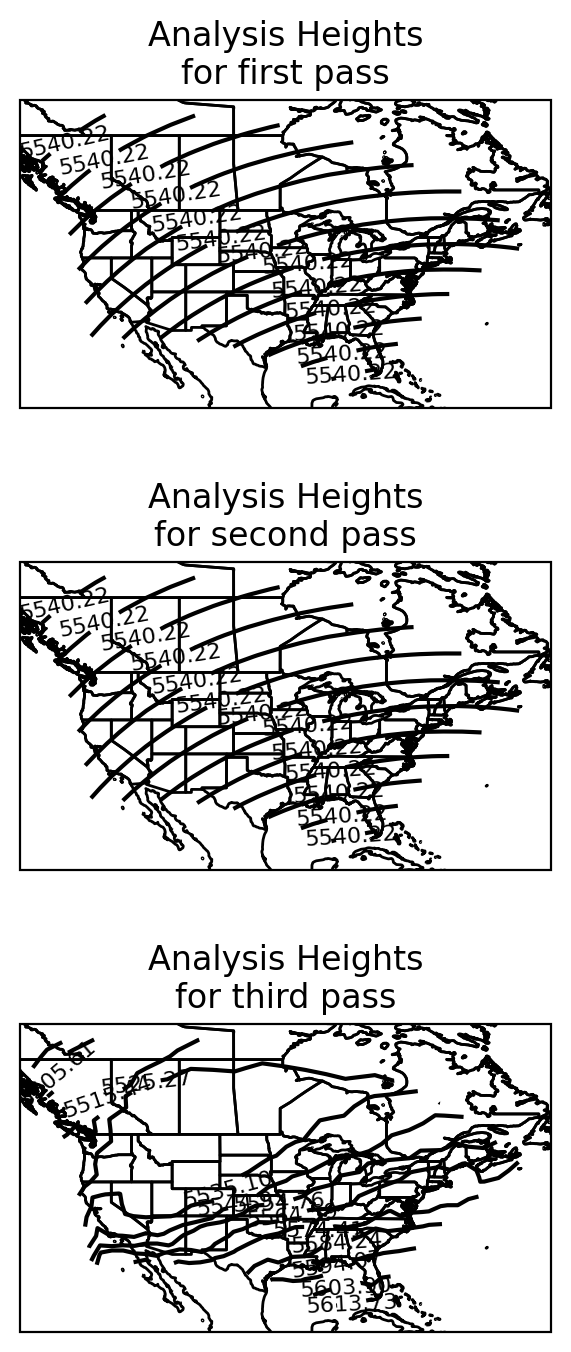

In [24]:
# Set up the figure and subplots with the specified projection
fig = plt.figure(figsize=(12, 8), dpi=200)

ax1 = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(3, 1, 3, projection=ccrs.PlateCarree())
plt.subplots_adjust(hspace=0.5)

# Define function to plot each analysis with dynamic levels
def plot_analysis(ax, data, title):
    # Determine contour levels dynamically based on data range
    vmin, vmax = np.nanmin(data), np.nanmax(data)
    levels = np.linspace(vmin, vmax, num=15)  # 15 levels for simplicity
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.set_title(title)

    # Plot contours with a color map for visibility
    cs = ax.contour(longitude_grid, latitude_grid, data, colors='k', levels=levels, transform=ccrs.PlateCarree())
    plt.clabel(cs, fmt="%.2f", fontsize=8)
    return cs

# Plot each analysis with dynamic titles and contours
cs1 = plot_analysis(ax1, Analysis1, 'Analysis Heights\nfor first pass')
cs2 = plot_analysis(ax2, Analysis2, 'Analysis Heights\nfor second pass')
cs3 = plot_analysis(ax3, Analysis3, 'Analysis Heights\nfor third pass')

plt.show()


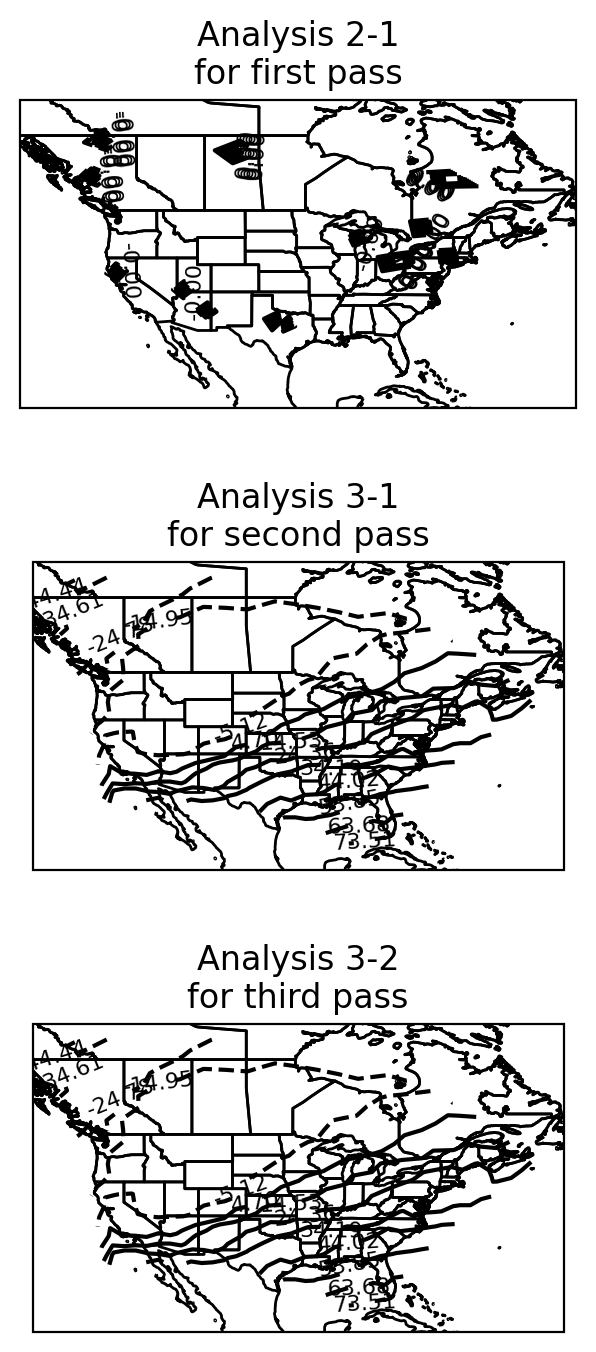

In [25]:
# Set up the figure and subplots with the specified projection
fig = plt.figure(figsize=(12, 8), dpi=200)

ax1 = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(3, 1, 3, projection=ccrs.PlateCarree())
plt.subplots_adjust(hspace=0.5)

# Define function to plot each analysis with dynamic levels
def plot_analysis(ax, data, title):
    # Determine contour levels dynamically based on data range
    vmin, vmax = np.nanmin(data), np.nanmax(data)
    levels = np.linspace(vmin, vmax, num=15)  # 15 levels for simplicity
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.set_title(title)

    # Plot contours with a color map for visibility
    cs = ax.contour(longitude_grid, latitude_grid, data, colors='k', levels=levels, transform=ccrs.PlateCarree())
    plt.clabel(cs, fmt="%.2f", fontsize=8)
    return cs

# Plot each analysis with dynamic titles and contours
cs1 = plot_analysis(ax1, diff_2_1, 'Analysis 2-1\nfor first pass')
cs2 = plot_analysis(ax2, diff_3_1, 'Analysis 3-1\nfor second pass')
cs3 = plot_analysis(ax3, diff_3_2, 'Analysis 3-2\nfor third pass')

plt.show()


**Saved files**

In [26]:
### Store the number of observations available for each grid point in text files ###
np.savetxt("Analysis_first_pass.txt", Analysis1, fmt="%.6f", header="Analysis Heights for First Pass")
np.savetxt("Analysis_second_pass.txt", Analysis2, fmt="%.6f", header="Analysis Heights for Second Pass")
np.savetxt("Analysis_third_pass.txt", Analysis3, fmt="%.6f", header="Analysis Heights for Third Pass")

np.savetxt("Diff_2_1.txt", Analysis1, fmt="%.6f", header="Analysis2-Analysis1")
np.savetxt("Diff_3_1.txt", Analysis2, fmt="%.6f", header="Analysis3-Analysis1")
np.savetxt("Diff_3_2.txt", Analysis3, fmt="%.6f", header="Analysis3-Analysis2")

**1 -** Describe the general features that you see in your contoured analyses.
Answer: 2nd pass analysis gives a clearer contour plot compared to the first and third pass analyses.

**2 -** Describe the differences that you see in your contoured analyses. Does one analysis seem to be smoother than the other?  If so, what would cause this?
Answer: 2nd pass analysis gives a clearer contour plot compared to the first and third pass analyses.

**3 - ** What happens as you increase the number of successive correction passes?  Is this desirable?  Why or why not?

Answer: